### Imports

In [1]:
import os
import shutil
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

### Dataset Splitting

In [2]:
dataset_dir = 'EuroSAT_RGB'
train_dir = 'EuroSAT_train'
test_dir = 'EuroSAT_test'
split = 0.8

random.seed(42)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(dataset_dir):
    source_class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(source_class_dir):
        continue
    images = [i for i in os.listdir(source_class_dir) if os.path.isfile(os.path.join(source_class_dir, i))]
    random.shuffle(images)
    split_idx = int(len(images) * split)

    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    for img in images[:split_idx]:
        shutil.copy(os.path.join(source_class_dir, img), os.path.join(train_class_dir, img))
    for img in images[split_idx:]:
        shutil.copy(os.path.join(source_class_dir, img), os.path.join(test_class_dir, img))

print("Split Complete!")
            

Split Complete!


### Dataset Images Transformations

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Loading The Dataset

In [4]:
dataset_path = "./EuroSAT"
train_dataset = torchvision.datasets.ImageFolder(root=dataset_path + "_train", transform=transform_train)
test_dataset = torchvision.datasets.ImageFolder(root=dataset_path + "_test", transform=transform_test)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Dataset Info

In [6]:
def dataset_info(loader, dataset_name="Dataset"):
    print(f"Dataset: {dataset_name}")
    print(f"Total samples: {len(loader.dataset)}")

    images, labels = next(iter(loader))
    print(f"Batch size: {images.shape[0]}")
    print(f"Image shape: {images.shape}")
    class_names = loader.dataset.classes
    unique_indicies = set(labels.numpy())
    unique_class_names = [class_names[i] for i in unique_indicies]
    print(f"Unique classes: {set(unique_class_names)}")
    print(f"Total classes: {len(class_names)}")

dataset_info(train_loader, "Training Set")

Dataset: Training Set
Total samples: 21600
Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Unique classes: {'Pasture', 'River', 'AnnualCrop', 'PermanentCrop', 'HerbaceousVegetation', 'Industrial', 'SeaLake', 'Highway', 'Residential', 'Forest'}
Total classes: 10


### Model Training

In [7]:
def train(num_epochs=10):
    train_losses, train_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    return train_losses, train_accuracies

### AlexNet Model Architecture

In [8]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Model, Loss Function & Optimizer

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Model Evaluation

In [10]:
def evaluate():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        accuracy = 100. * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")
        return accuracy

### Model Inferencing

In [16]:
def predict(image_path):
    image = Image.open(image_path)
    image = transform_test(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = output.max(1)
        class_names = train_dataset.classes
    print(f"Predicted Class: {class_names[predicted.item()]}")
    return predicted.item()

### Visualization of Loss & Accuracy

In [12]:
def plot_metrics(train_losses, train_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

### Training The Model

##################################################
Training Started
Epoch 1, Loss: 1.6299, Accuracy: 36.09%
Epoch 2, Loss: 1.1792, Accuracy: 55.45%
Epoch 3, Loss: 0.9976, Accuracy: 63.80%
Epoch 4, Loss: 0.9080, Accuracy: 67.40%
Epoch 5, Loss: 0.8262, Accuracy: 70.61%
Epoch 6, Loss: 0.7771, Accuracy: 72.25%
Epoch 7, Loss: 0.7495, Accuracy: 73.34%
Epoch 8, Loss: 0.7406, Accuracy: 74.08%
Epoch 9, Loss: 0.7041, Accuracy: 74.91%
Epoch 10, Loss: 0.7089, Accuracy: 75.08%
Epoch 11, Loss: 0.7535, Accuracy: 74.75%
Epoch 12, Loss: 0.6930, Accuracy: 75.38%
Epoch 13, Loss: 0.6746, Accuracy: 75.93%
Epoch 14, Loss: 0.6792, Accuracy: 76.14%
Epoch 15, Loss: 0.7580, Accuracy: 73.51%
Training Completed
##################################################
Model Evaluation Started
Test Accuracy: 77.74%
Model Evaluation Completed
##################################################
Plotting The Metrics


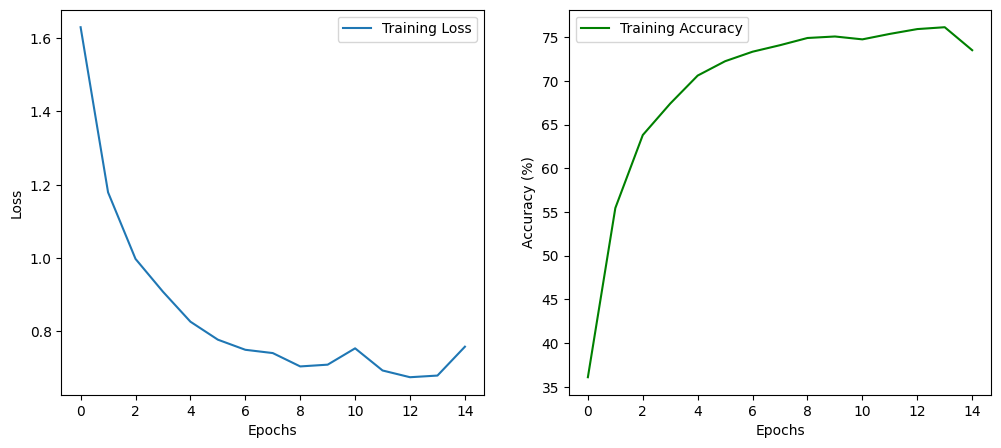

In [13]:
print('#' * 50)
print('Training Started')
train_losses, train_accuracies = train(num_epochs=15)
print('Training Completed')
print('#' * 50)
print('Model Evaluation Started')
evaluate()
print('Model Evaluation Completed')
print('#' * 50)
print('Plotting The Metrics')
plot_metrics(train_losses, train_accuracies)

In [17]:
predict("./EuroSAT_test/PermanentCrop/PermanentCrop_294.jpg")

Predicted Class: PermanentCrop


6

In [18]:
torch.save(model.state_dict(), 'EuroSAT_15_epochs_with_augmentation.pth')